In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

2024-10-22 23:02:37.680986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 23:02:37.757496: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 23:02:37.773868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 23:02:37.866701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 23:02:39.096161: W tensorflow/compiler/tf2

## Extract Faces

No. of faces: 1


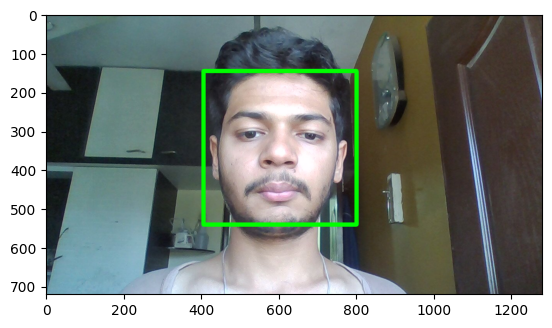

In [2]:
# def skin_filter(img):
#     '''
#     Hightlight skin color and other colors are made black

#     Arg: 
#         img ndarray()
#     Returns:
#         skin_mask ndarray()
#     '''
#     hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#     lower_skin = np.array([0, 20, 70], dtype=np.uint8)
#     upper_skin = np.array([20, 255, 255], dtype=np.uint8)

#     skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
#     skin = cv2.bitwise_and(img, img, mask=skin_mask)
#     skin_mask= cv2.cvtColor(skin, cv2.COLOR_BGR2RGB)
#     return skin_mask

def extract_faces(img: np.ndarray):
    '''
    Return list of face bounding box coordinates with eye coordinates

    Args:
        img: numpy.ndrray() assuming input image is rgb format
    Returns:
        faces: numpy.ndrray(n, 4): where n is no of faces presetn in the image  
    '''
    # img = skin_filter(img)

    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    gray_image = cv2.equalizeHist(gray_image)
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )


    face_boxes = face_classifier.detectMultiScale(
        gray_image, scaleFactor=1.2, minNeighbors=5, minSize=(100, 100)
    )

    return face_boxes

# Test
# imagePath = "images/Test/3.jpg"   
imagePath = "images/Train/6.jpg"   
img_temp = cv2.imread(imagePath)
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)

ans = extract_faces(img_temp)
print(f"No. of faces: {len(ans)}")
for x,y,w,h in ans:
    cv2.rectangle(img_temp, (x, y), (x + w, y + h), (0, 255, 0), 10)
    

plt.imshow(img_temp)
plt.show()

## Face aligment 
- Will work on later 

## Resize images

No. of faces: 1


TensorShape([1, 224, 224, 3])

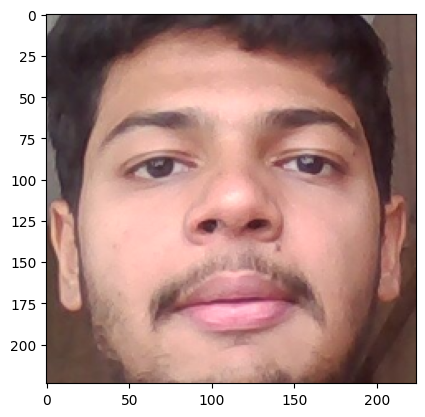

In [3]:
def resize(boxes: np.ndarray, img: np.ndarray, size=(224, 224)):
    '''
    Returns resized images of size 224 by 224 

    Args:
        boxes ndrray(n, 4): n is number of faces and each face has [x, y, w, h]
        img ndrray(): image with faces
        size tuple(h, w)
    Return:
        imgs tensor(n, 224, 224, 3)
    '''
    faces = []
    for (x,y,w,h) in boxes:
        face = img[y:y+h+1, x: x+w+1, :]
        face = tf.image.resize(face, size)
        faces.append(face)
    
    faces = tf.stack(faces)
    return faces

# test 
imagePath = "Trash/aditya3.jpg"
img_temp = cv2.imread(imagePath)
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)

ans = extract_faces(img_temp)
print(f"No. of faces: {len(ans)}")
faces = resize(ans, img_temp)
plt.imshow(faces[0]/255)
faces.shape


## Preprocessing pipeline

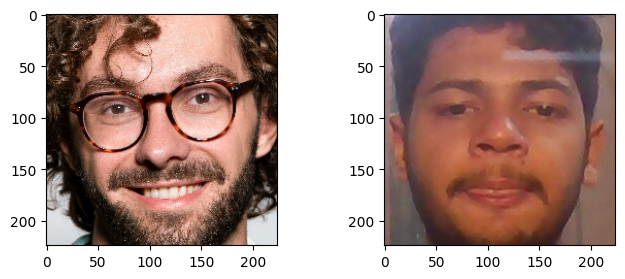

In [4]:
def preprocess_pipe(img: np.ndarray):
    '''
    Do face extraction and resizeing the image in one go. Assuming the image is rgb format.

    Args:
        img ndarray(): image must be in RGB fromat
    Returns:
        face_imgs 
    '''

    face_boxes = extract_faces(img)
    face_imgs = resize(face_boxes, img, size=(224, 224))

    return face_imgs

# test
img_temp = cv2.imread('Trash/person.jpg')
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
img_temp2 = cv2.imread('Trash/aditya2.jpg')
img_temp2 = cv2.cvtColor(img_temp2, cv2.COLOR_BGR2RGB)


face_imgs1 = preprocess_pipe(img_temp)
face_imgs2 = preprocess_pipe(img_temp2)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax.flat[0].imshow(face_imgs1[0]/255)
ax.flat[1].imshow(face_imgs2[0]/255)

## Embeddings Generator
- Model is used as embeddings generator

In [5]:
base_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights="imagenet",
    name='MobileNet_BaseModel'
)

model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
        base_model
    ]
)

model.trainable=False
model.compile()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNet_BaseModel             │ (None, 1024)           │     3,228,864 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNet_BaseModel             │ (None, 1024)           │     3,228,864 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [7]:
# model.save('model.keras')

No. of faces 1: 1
No. of faces 2: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Euclidian: 17.901533126831055
Cosine: 0.8253275752067566


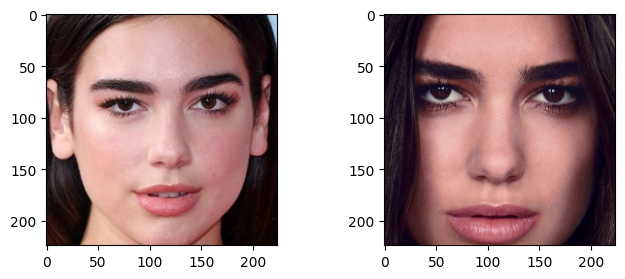

In [8]:
# Testing model
from utils.encoder import Encoder
encoder = Encoder()

img_temp = cv2.imread('images/Train/1.jpg')
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
img_temp2 = cv2.imread('images/Test/1.jpg')
img_temp2 = cv2.cvtColor(img_temp2, cv2.COLOR_BGR2RGB)

faces=preprocess_pipe(img_temp)
faces2=preprocess_pipe(img_temp2)
print(f"No. of faces 1: {len(faces)}")
print(f"No. of faces 2: {len(faces2)}")
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax.flat[0].imshow(faces[0]/255)
ax.flat[1].imshow(faces2[0]/255)

answer = model.predict(faces)
answer2 = model.predict(faces2)


def cosine_similarity(a, b):
    """Calculates the cosine similarity between two 1D numpy arrays."""
    a = a/ np.linalg.norm(a)
    b = b/ np.linalg.norm(b)

    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)


def euclidean_similarity(embedding1, embedding2):
    # Ensure the inputs are numpy arrays
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)
    
    # Compute Euclidean distance
    distance = np.linalg.norm(embedding1 - embedding2)
    
    return distance

eSimilarity = euclidean_similarity(answer[0], answer2[0])
cSimilarity = cosine_similarity(answer[0], answer2[0])
print(f"Euclidian: {eSimilarity}")
print(f"Cosine: {cSimilarity}")

## How to Generate Embeddings

To generate embedding of am image you need to do following thing

```
# img must be numpy array with RGB format
embeddings = model.predict(face_imgs)
```

In [9]:
img_temp = cv2.imread('Trash/4.jpg')
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)

face_boxes = extract_faces(img_temp)
face_imgs = preprocess_pipe(img_temp)
print(f"No of faces: {len(face_imgs)}")

embeddings = model.predict(face_imgs)

print(f"len(embeddings): {embeddings.shape}")
print(f"First five values of embeedings: {embeddings[0][:5]}")
print(f"Min {np.min(embeddings[0])} Max: {np.max(embeddings[0])}")

No of faces: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
len(embeddings): (4, 1024)
First five values of embeedings: [0.05715288 0.03550353 0.00887598 0.32206205 0.06638931]
Min 0.0 Max: 5.141200065612793
